In [18]:
from tensorflow import keras
model = keras.models.load_model("keras_model_dataset_50x.h5")
print("modelo cargado")

modelo cargado


In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,388 (427.30 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [6]:
from pathlib import Path

base_images_dir = Path("../Dataset_emocional")  # <-- AJUSTA ESTE NOMBRE

if not base_images_dir.exists():
    raise FileNotFoundError(f"No se encontró la carpeta: {base_images_dir.resolve()}")

print("Usando carpeta de imágenes:", base_images_dir.resolve())
print("Subcarpetas:", [p.name for p in base_images_dir.iterdir() if p.is_dir()])

Usando carpeta de imágenes: C:\Users\cance\Documents\GitHub\Sentimental_emoji_classifier\Dataset_emocional
Subcarpetas: ['Enojado', 'Feliz', 'Triste']


In [43]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path

IMG_SIZE = (224, 224)  # tamaño para el modelo de visión

def normalize_folder_images(folder_path, img_size=IMG_SIZE):
    folder_path = Path(folder_path)
    for img_path in tqdm(list(folder_path.rglob("*")), desc=f"Normalizando {folder_path.name}"):
        if not img_path.is_file():
            continue
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB")
                img = img.resize(img_size)
                # Guardar siempre como .jpg
                new_path = img_path.with_suffix(".jpg")
                img.save(new_path, format="JPEG", quality=95)
                if new_path != img_path:
                    img_path.unlink(missing_ok=True)
        except Exception as e:
            print("Error con", img_path, ":", e)

# Aplicar a las tres carpetas (triste, feliz, enojado)
for sub in ["triste", "feliz", "enojado"]:
    folder = base_images_dir / sub
    if folder.exists():
        normalize_folder_images(folder)
    else:
        print("No se encontró carpeta:", folder)

Normalizando enojado: 100%|██████████| 30/30 [00:00<00:00, 670.05it/s]


In [44]:
from PIL import Image
import random
from pathlib import Path
from tqdm import tqdm

def augment_folder_images(folder_path, target_count=200):
    """
    Genera imágenes augmentadas (rotaciones, zoom, brillo, etc.)
    para cada clase hasta alcanzar target_count imágenes
    """
    folder_path = Path(folder_path)
    original_images = list(folder_path.glob("*.jpg"))
    
    if len(original_images) == 0:
        print(f"No hay imágenes en {folder_path}")
        return
    
    current_count = len(original_images)
    images_to_create = max(0, target_count - current_count)
    
    print(f"\n{folder_path.name}: {current_count} originales -> generando {images_to_create} augmentadas")
    
    for i in tqdm(range(images_to_create), desc=f"Augmentando {folder_path.name}"):
        # Seleccionar imagen original aleatoria
        original = random.choice(original_images)
        
        with Image.open(original) as img:
            # Aplicar transformaciones aleatorias
            augmented = img.copy()
            
            # 1. Rotación aleatoria (±15 grados)
            if random.random() > 0.5:
                angle = random.randint(-15, 15)
                augmented = augmented.rotate(angle, fillcolor='white')
            
            # 2. Zoom (crop y resize)
            if random.random() > 0.5:
                zoom = random.uniform(0.85, 1.0)
                w, h = augmented.size
                left = int((w - w*zoom) / 2)
                top = int((h - h*zoom) / 2)
                right = left + int(w*zoom)
                bottom = top + int(h*zoom)
                augmented = augmented.crop((left, top, right, bottom))
                augmented = augmented.resize((28, 28), Image.Resampling.LANCZOS)
            
            # 3. Cambiar brillo
            if random.random() > 0.5:
                from PIL import ImageEnhance
                enhancer = ImageEnhance.Brightness(augmented)
                augmented = enhancer.enhance(random.uniform(0.8, 1.2))
            
            # 4. Cambiar contraste
            if random.random() > 0.5:
                from PIL import ImageEnhance
                enhancer = ImageEnhance.Contrast(augmented)
                augmented = enhancer.enhance(random.uniform(0.8, 1.2))
            
            # 5. Flip horizontal aleatorio
            if random.random() > 0.5:
                augmented = augmented.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
            
            # Guardar con nombre único
            new_filename = f"{original.stem}_aug_{i}.jpg"
            new_path = folder_path / new_filename
            augmented.save(new_path, format="JPEG", quality=95)

# Aplicar augmentation a las tres carpetas
emotions = ["enojado", "feliz", "triste"]
for emotion in emotions:
    folder = base_images_dir / emotion
    if folder.exists():
        augment_folder_images(folder, target_count=200)
    else:
        print(f"No se encontró carpeta: {folder}")

print("\n✓ Data augmentation completada")



enojado: 30 originales -> generando 170 augmentadas


Augmentando enojado: 100%|██████████| 170/170 [00:00<00:00, 269.19it/s]




feliz: 29 originales -> generando 171 augmentadas


Augmentando feliz: 100%|██████████| 171/171 [00:00<00:00, 262.81it/s]



triste: 30 originales -> generando 170 augmentadas


Augmentando triste: 100%|██████████| 170/170 [00:00<00:00, 290.96it/s]


✓ Data augmentation completada


In [45]:
import tensorflow as tf

train_val_dir = str(base_images_dir)  # contiene triste, feliz, enojado
batch_size = 32

# IMPORTANTE: Usar el tamaño que espera el modelo original (28x28)
ORIGINAL_IMG_SIZE = (28, 28)

train_ds = keras.utils.image_dataset_from_directory(
    train_val_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=ORIGINAL_IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale'  # Convertir a escala de grises (1 canal)
)

val_ds = keras.utils.image_dataset_from_directory(
    train_val_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=ORIGINAL_IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale'  # Convertir a escala de grises (1 canal)
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)
print("num_classes:", num_classes)
print("Tamaño de imagen:", ORIGINAL_IMG_SIZE)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 600 files belonging to 3 classes.
Using 480 files for training.
Using 480 files for training.
Found 600 files belonging to 3 classes.
Using 120 files for validation.
Found 600 files belonging to 3 classes.
Using 120 files for validation.
Clases: ['Enojado', 'Feliz', 'Triste']
num_classes: 3
Tamaño de imagen: (28, 28)
Clases: ['Enojado', 'Feliz', 'Triste']
num_classes: 3
Tamaño de imagen: (28, 28)


In [54]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Normalizar e APLANAR imágenes (valores entre 0 y 1, forma (784,))
train_ds_normalized = train_ds.map(lambda x, y: (tf.reshape(x / 255.0, (-1, 784)), y))
val_ds_normalized = val_ds.map(lambda x, y: (tf.reshape(x / 255.0, (-1, 784)), y))

# Cargar el modelo pre-entrenado
base_model = model

# Ver arquitectura del modelo original
print("Capas del modelo original:")
for i, layer in enumerate(base_model.layers):
    print(f"{i}: {layer.name} - {layer.__class__.__name__}")

# Crear modelo sin la última capa (Dense de 10 salidas)
new_model = keras.Sequential()
for layer in base_model.layers[:-1]:
    new_model.add(layer)

# Añadir la nueva capa de 3 salidas
new_model.add(layers.Dense(3, activation="softmax", name="emotions"))

# Compilar con learning rate bajo para fine-tuning
new_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

new_model.summary()

# Entrenar con los nuevos datos emocionales (triste, feliz, enojado)
epochs = 200

# Early stopping para evitar overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

history = new_model.fit(
    train_ds_normalized,
    validation_data=val_ds_normalized,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Guardar el modelo refinado con 3 salidas
new_model.save("keras_model_emociones_3salidas.h5")
print("Modelo de emociones (3 salidas) guardado")

# Mostrar mapping de clases
print("\nMapping de emociones:")
for idx, emotion in enumerate(class_names):
    print(f"{idx}: {emotion}")

Capas del modelo original:
0: dense - Dense
1: dense_1 - Dense
2: dense_2 - Dense


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ emotions (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,736 (424.75 KB)

 Trainable params: 108,736 (424.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3500 - loss: 8.8350 - val_accuracy: 0.3250 - val_loss: 4.8166
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3500 - loss: 8.8350 - val_accuracy: 0.3250 - val_loss: 4.8166
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3417 - loss: 3.2735 - val_accuracy: 0.4167 - val_loss: 1.8162
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3417 - loss: 3.2735 - val_accuracy: 0.4167 - val_loss: 1.8162
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4583 - loss: 1.4661 - val_accuracy: 0.4083 - val_loss: 1.5551
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4583 - loss: 1.4661 - val_accuracy: 0.4083 - val_loss: 1.5551
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5250 - loss: 1.1832 - val_accuracy: 0.4917 - val_loss: 1.2456
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5250 - loss: 1.1832 - val_accuracy: 0.4917 -

Modelo de emociones (3 salidas) guardado

Mapping de emociones:
0: Enojado
1: Feliz
2: Triste


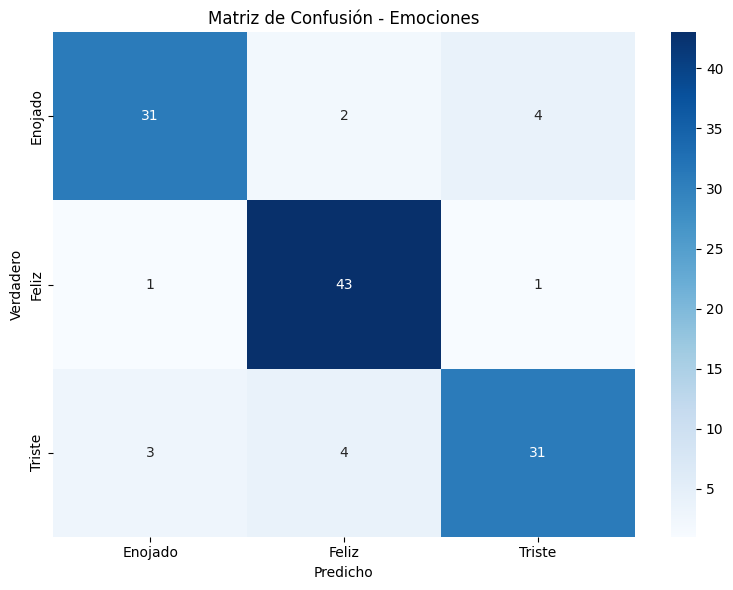


Reporte de Clasificación:
              precision    recall  f1-score   support

     Enojado       0.89      0.84      0.86        37
       Feliz       0.88      0.96      0.91        45
      Triste       0.86      0.82      0.84        38

    accuracy                           0.88       120
   macro avg       0.87      0.87      0.87       120
weighted avg       0.87      0.88      0.87       120



In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener predicciones en el conjunto de validación
y_true = []
y_pred = []

for x_batch, y_batch in val_ds_normalized:
    predictions = new_model.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(y_batch.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Crear matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - Emociones')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

# Mostrar reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))


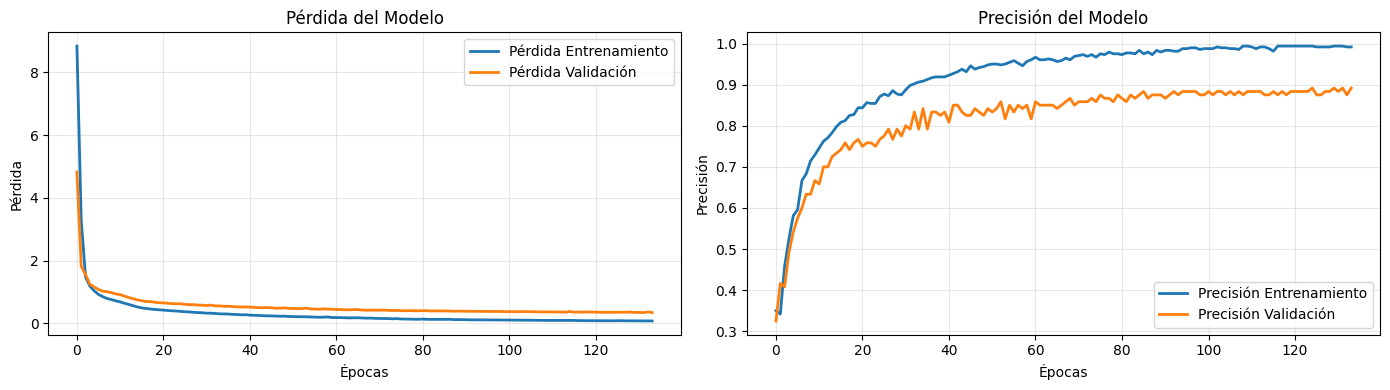

Épocas entrenadas: 134
Pérdida final entrenamiento: 0.0733
Pérdida final validación: 0.3402
Precisión final entrenamiento: 0.9917
Precisión final validación: 0.8917


In [57]:
import matplotlib.pyplot as plt

# Gráfico de Pérdida (Loss)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Gráfico 1: Loss (Pérdida)
axes[0].plot(history.history['loss'], label='Pérdida Entrenamiento', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Pérdida Validación', linewidth=2)
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Pérdida')
axes[0].set_title('Pérdida del Modelo')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Accuracy (Precisión)
axes[1].plot(history.history['accuracy'], label='Precisión Entrenamiento', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Precisión Validación', linewidth=2)
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Precisión')
axes[1].set_title('Precisión del Modelo')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Épocas entrenadas: {len(history.history['loss'])}")
print(f"Pérdida final entrenamiento: {history.history['loss'][-1]:.4f}")
print(f"Pérdida final validación: {history.history['val_loss'][-1]:.4f}")
print(f"Precisión final entrenamiento: {history.history['accuracy'][-1]:.4f}")
print(f"Precisión final validación: {history.history['val_accuracy'][-1]:.4f}")


Total de imágenes disponibles: 600
✓ Imagen seleccionada: ..\Dataset_emocional\Triste\triste_01.jpg
  Carpeta: Triste


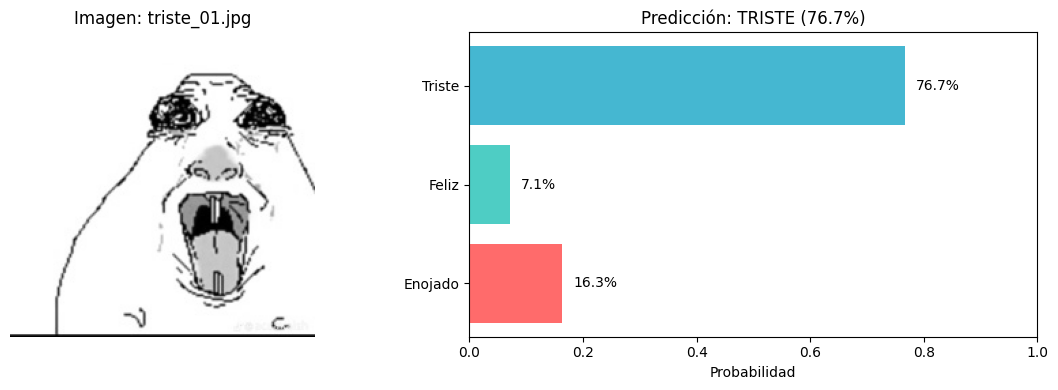


✓ Predicción: Triste
Confianza: 76.65%

Detalles:
  Enojado: 16.28%
  Feliz: 7.07%
  Triste: 76.65%


In [61]:
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Obtener todas las imágenes del dataset
all_images = list(base_images_dir.rglob("*.jpg"))
print(f"Total de imágenes disponibles: {len(all_images)}")

# Seleccionar imagen por nombre
image_name = "triste_01.jpg"  # <-- CAMBIA ESTE NOMBRE POR LA IMAGEN QUE QUIERAS

# Buscar imagen por nombre
selected_image_path = None
for img_path in all_images:
    if image_name.lower() in img_path.name.lower():
        selected_image_path = img_path
        break

if selected_image_path is None:
    print(f"❌ No se encontró imagen con nombre '{image_name}'")
    print("\nImágenes disponibles (primeras 10):")
    for img_path in sorted(all_images)[:10]:
        print(f"  • {img_path.parent.name}/{img_path.name}")
    if len(all_images) > 10:
        print(f"  ... y {len(all_images) - 10} más")
else:
    print(f"✓ Imagen seleccionada: {selected_image_path}")
    print(f"  Carpeta: {selected_image_path.parent.name}")
    
    # Cargar y procesar la imagen
    img = Image.open(selected_image_path).convert('L')
    img_resized = img.resize((28, 28))
    img_array = np.array(img_resized) / 255.0
    img_flattened = img_array.flatten().reshape(1, -1)
    
    # Hacer predicción
    prediction = new_model.predict(img_flattened, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    # Mostrar resultado
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Imagen original
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title(f"Imagen: {selected_image_path.name}")
    axes[0].axis('off')
    
    # Gráfico de probabilidades
    emotions_list = class_names
    probabilities = prediction[0]
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    axes[1].barh(emotions_list, probabilities, color=colors)
    axes[1].set_xlabel('Probabilidad')
    axes[1].set_title(f'Predicción: {emotions_list[predicted_class].upper()} ({confidence*100:.1f}%)')
    axes[1].set_xlim([0, 1])
    
    for i, (emotion, prob) in enumerate(zip(emotions_list, probabilities)):
        axes[1].text(prob + 0.02, i, f'{prob*100:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Predicción: {emotions_list[predicted_class]}")
    print(f"Confianza: {confidence*100:.2f}%")
    print(f"\nDetalles:")
    for emotion, prob in zip(emotions_list, probabilities):
        print(f"  {emotion}: {prob*100:.2f}%")
